# Introduction to Privacy Preserving Machine Learning

Course taught by Aurélien Bellet

- Victor NIAUSSAT
- Victor CILLEROS

# Lab session: Gaussian mechanism and Differentially Private SGD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml  # need sklearn >= 0.22
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

D:\LOGICIELS\ANACONDA\envs\env_sdi\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <font color=red>Instructions for submitting your report</font>

<font color=red>The deadline for sending your report is **Friday, February 17, 2022 at 23h55**.
The report is **by teams of 2 students**, should only consist of a **single** `ipynb` file (Jupyter notebook) with your names indicated clearly, and be **submitted via Moodle** (Décision et apprentissage > TP Privacy-Preserving ML > Rendu TP).

The grade will be over 20 points, broken down as follows:
- Quality of your answers to the questions: **17** points
- Quality of the writing and presentation: **2** points
- Absence of any bug: **1** point

Penalties: **5** points per 12 hours of extra time; **2** points for any failure to respect the other instructions above.</font>

## Part 1: Gaussian mechanism on simple numeric queries

In this first part, we will implement the Gaussian mechanism and experiment with simple numeric queries.

### Dataset

We will be working with a dataset from the US Census (also known as the Adult dataset). You can read about the dataset [here](https://archive.ics.uci.edu/ml/datasets/census+income).

The following line loads the dataset from [OpenML](https://www.openml.org/) with the `fetch_openml` method of `sklearn`. The option `as_frame=True` (**requires sklearn version >= 0.22**) loads the dataset in `pandas DataFrame` format: this keeps the attributes in their original form and will be more convenient to work with.

In [3]:
dataset_handle = fetch_openml(name='adult', version=2, as_frame=True)
dataset = dataset_handle.frame

Take a look at the dataset, in particular the number of rows (individuals), the number of columns (attributes) and what they represent.

In [4]:
n, d = dataset.shape
print(f"Shape of dataset : ({n}, {d})")
dataset.head(10)

Shape of dataset : (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
5,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
6,29.0,NaN,227026.0,HS-grad,9.0,Never-married,NaN,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
7,63.0,Self-emp-not-inc,104626.0,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103.0,0.0,32.0,United-States,>50K
8,24.0,Private,369667.0,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
9,55.0,Private,104996.0,7th-8th,4.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,10.0,United-States,<=50K


### Question 1.1 (non-private queries)

Implement a function for each of these types of queries (without privacy) and test them on the dataset:
- **Simple count queries**: it takes as input a dataset (`DataFrame`), a categorical attribute (e.g., `"sex"`) and a value (e.g., `Male`), and returns how many rows in the dataset have the prescribed attribute value.
- **Averaging queries**: it takes as input a dataset and a numeric attribute (e.g., `"age"`), and returns the average value of this attribute in the dataset.
- **Histogram queries**: it takes as input a dataset and a categorical attribute (e.g., `"sex"`), and returns the histogram of counts for this attribute in the dataset (i.e., for each possible value of the attribute, how many rows have this value).

Reminder: for a DataFrame `df`, we can access the column corresponding to an attribute `attr` by `df[attr]`. The method `value_counts()` allows to build a histogram of a column.

Note: you can use the function `bar_plot_pandas` provided below to draw a bar plot of a pandas Series, which is useful to show histograms.

In [5]:
def bar_plot_pandas(series1, series2=None, label1="Series 1", label2="Series 2", title=""):
    '''
    Draws a bar plot of one Pandas Series, or two pandas Series with the same index
    
    Parameters
    ----------
    series1 : Series of float
        First input
    series2 : Series of float, optional
        Second input (with same index)
    label1 : string, optional
        Label for the first series
    label2 : string, optional
        Label for the second series
    title : string, optional
        Plot title
    '''
    if series2 is None:
        series1.plot.bar()
        plt.legend([label1])
    else:
        concat_series = pd.DataFrame({label1: series1, label2: series2}).reset_index()
        concat_series.plot.bar(x="index", y=[label1, label2], xlabel="", title=title)

In [6]:
def count_query(df, attribute, value):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
    value : string or int
        Value of attribute to count
        
    Returns
    -------
    count : int
        The number of records with `attribute=value` in dataset `df`
    '''
    #Done 
    return len(df[df[attribute] == value])

In [7]:
def average_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with numeric values
        
    Returns
    -------
    average : float
        The average value of `attribute` in dataset `df`
    '''
        
    # DONE
    return df[attribute].mean()

In [8]:
def histogram_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
        
    Returns
    -------
    histogram : array or Series of int
        The histogram of `attribute`, i.e., the number of times each value of `attribute` appears in `df`
    '''
    # DONE
    return df[attribute].value_counts() #.plot(kind='bar')

### Question 1.2 (Gaussian mechanism)

Implement the Gaussian mechanism, i.e., a function which takes as input a (non-private) query output, the query's $\ell_2$ sensitivity, the desired value of $\epsilon$ and $\delta$ and a random seed (for reproducibility), and returns a $(\epsilon,\delta)$-differentially private estimate of the query. To draw Gaussian noise, check `np.random.normal`. The function should work with queries that output a scalar (like simple count and averaging queries), as well as those that output a vector (like histogram queries).

In [9]:
def gaussian_mechanism(q, s2, eps, delta, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s2 : float
        The L2 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or array/Series of float
        An (eps,delta)-DP evaluation of the query
    '''
    
    rng = np.random.RandomState(random_state)
    sigma = np.sqrt( 2*np.log(1.25/delta) ) * s2 /eps
    # DONE
    if hasattr(q, 'shape'): # query output is multi-dimensional
        y = rng.normal(0, sigma, q.shape)
    else: # query output is a scalar
        y = rng.normal(0, sigma)
    return q+y

Test des fonctions : 

--> cf test unitaires pour les résulats

Count on occupation = Machine-op-inspct : 3022 
Average on age :(38.64358543876172, 1079.0676262233324) 


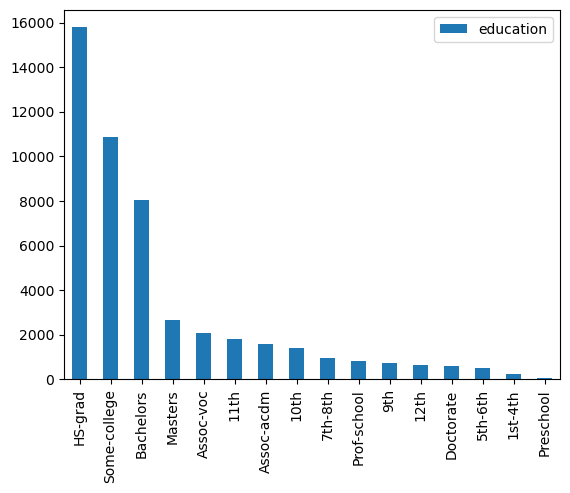

In [10]:
count = count_query(dataset, "occupation", "Machine-op-inspct")
average = average_query(dataset, "age"), average_query(dataset, "capital-gain")
print(f"Count on occupation = Machine-op-inspct : {count} ")
print(f"Average on age :{average} ")
bar_plot_pandas(histogram_query(dataset, "education"), label1="education")

### Question 1.3 (Private computation of count queries)

We would like to use the Gaussian mechanism to:
- privately count the number of males in the dataset
- generate a private histogram of the `"workclass"` attribute

What is the sensitivity of the query in each case?

Run the Gaussian mechanism with different values of $\epsilon$ and $\delta$, and compute the relative $\ell_1$-error with respect to the true (non-private) output and discuss the effect of $\epsilon$ and $\delta$ on the utility. Recall that the mechanism is random, so unless you fix the seed you will get a different result at each execution. You may also visually compare the private and non-private histograms using the function `bar_plot_pandas` provided at the beginning of the notebook.

Note: you may round the outputs of the private mechanism to make them integers if you like. This can be seen as post-processing and thus preserves DP.

In [11]:
def relative_l1_error(q_true, q_est):
    '''
    Parameters
    ----------
    q_true : float or array/Series of float
        True value
    q_est : float or array/Series of float
        Estimated value
        
    Returns
    -------
    l1_error : float
        The relative L1 error of `q_est` with respect to and `q_true`: ||q_true-q_est||_1 / ||q_true||_1
    '''

    if not(hasattr(q_true, 'shape')):
        return np.abs(q_true - q_est) / np.abs(q_true)
    else:
        return np.linalg.norm(q_true - q_est, ord=1) / np.linalg.norm(q_true, ord=1)

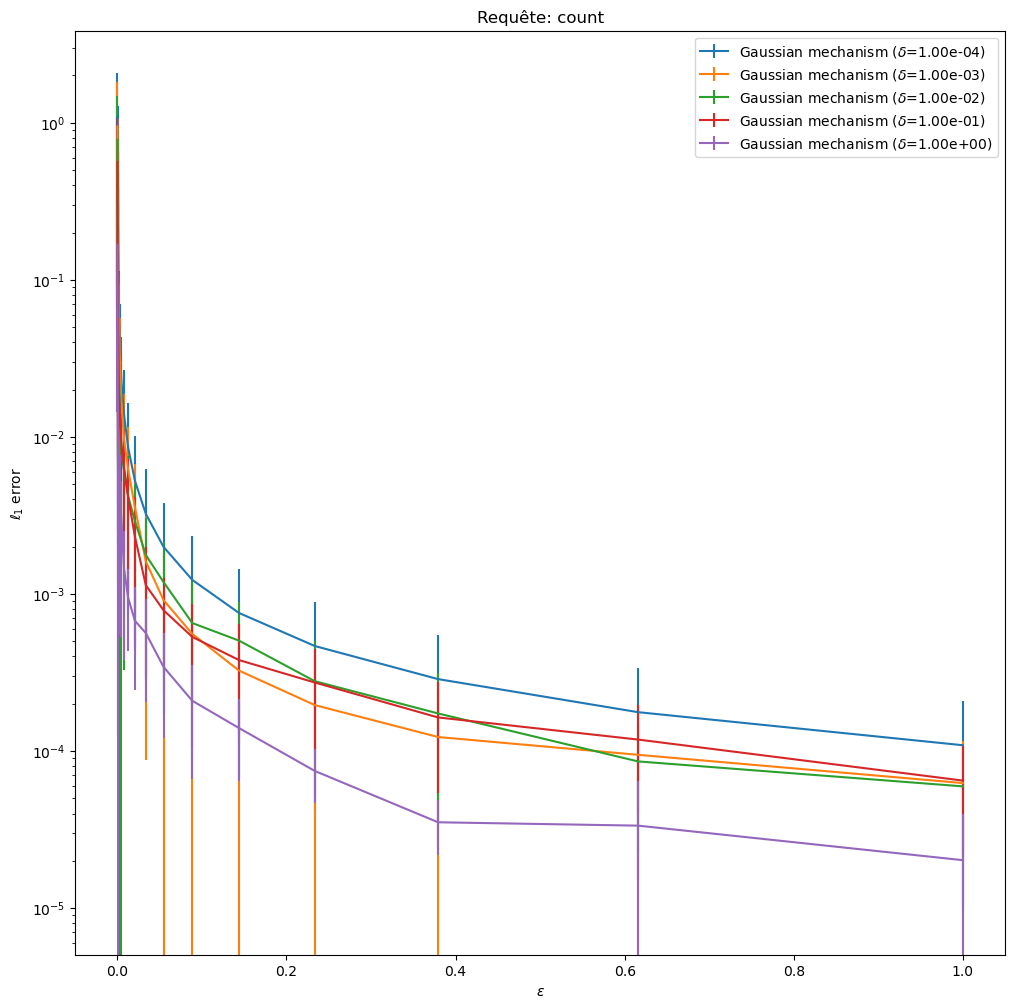

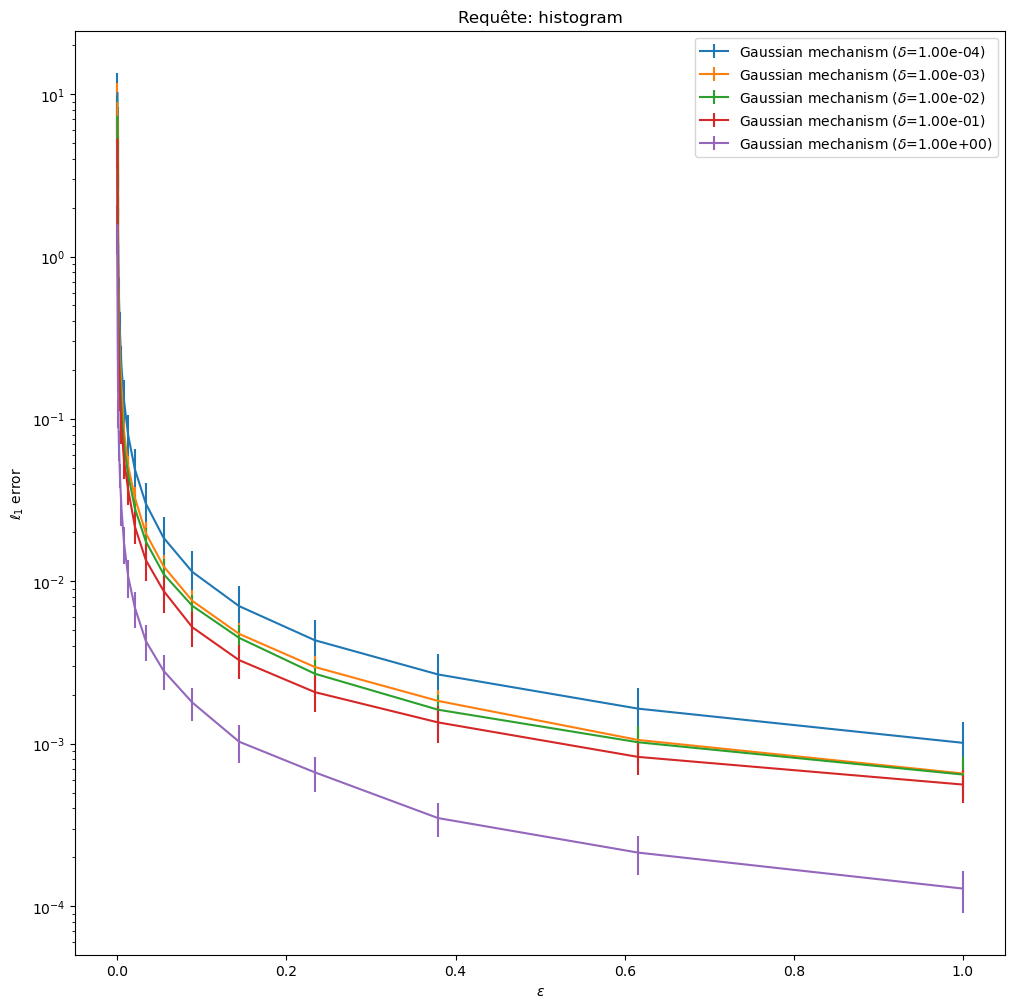

In [12]:
# fill with the list of queries in the format (name, query_function, sensitivity)
queries = [( "count"    , count_query(dataset, "sex", "Male")  , 1 ), 
           ( "histogram", histogram_query(dataset, "workclass"), np.sqrt(2) )]

# fill with the list of values for epsilon and delta
eps_list = np.geomspace(0.0001, 1, num=20)
delta_list = np.geomspace(0.0001, 1, num=5)
n_runs = 10

for name, q, s in queries:
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1, 1, 1)
    error = np.zeros((len(eps_list), len(delta_list), n_runs))
    for j, delta in enumerate(delta_list):
        for i, eps in enumerate(eps_list):
            for r in range(n_runs):
                # DONE
                q_true = q
                q_est = gaussian_mechanism(q_true, s, eps, delta, random_state=i*j+r)
                error[i, j, r] = relative_l1_error(q_true,q_est)
    
        ax.errorbar(eps_list, error[:, j, :].mean(axis=1), error[:, j, :].std(axis=1),
                    label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta) + ')')

    plt.xlabel("$\epsilon$")
    plt.ylabel("$\ell_1$ error")
    plt.title("Requête: " + name)
    ax.set_yscale('log')
    ax.legend()

**Visualisation** \
Comparaison entre les histrogrammes privé et non-privé : 


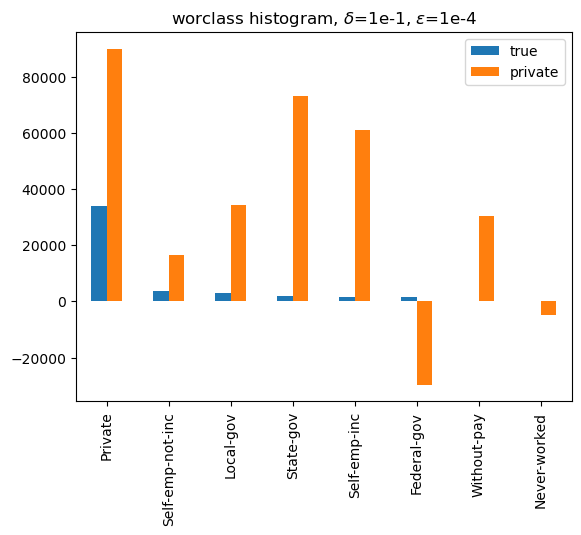

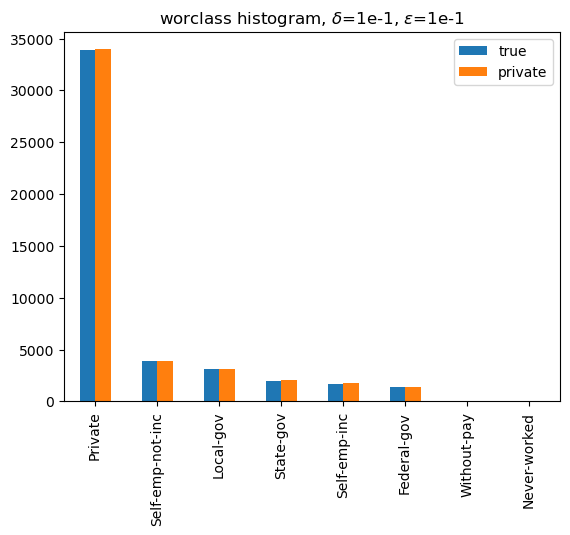

In [13]:
hist_workclass = histogram_query(dataset, "workclass")
bar_plot_pandas(hist_workclass, series2=gaussian_mechanism(hist_workclass, np.sqrt(2), eps=1e-4, delta=1e-1, random_state=0),
                label1="true", label2="private", title= "worclass histogram, $\delta$=1e-1, $\epsilon$=1e-4" )
bar_plot_pandas(hist_workclass, series2=gaussian_mechanism(hist_workclass, np.sqrt(2), eps=1e-1, delta=1e-1, random_state=0),
                label1="true", label2="private", title="worclass histogram, $\delta$=1e-1, $\epsilon$=1e-1" )

Nous constatons que plus les valeurs de $\delta$ et $\epsilon$ sont petites plus la différence entre les résultats privés et non provés est grande. C'est normal puisqu'il s'agit d'un compromis à faire entre sécurité et utilité. Plus les requêtes sont privatisées, plus l'information est "fausée".

Le cours donne la borne théorique : 

$Pr \left[∥\mathcal{A}_{Gauss}(D, f, ε) − f(D)∥_{∞} < \sqrt{2 ln(1.25/δ) ln(K/β)} \frac{∆_2(f)}{ ε} \right]≥ 1 − β.$


### <font color='blue'>Bonus Question</font> (Private computation of  average queries)
*(You won't be penalized if you don't answer this question; but can get bonus points if you do)*

We would like to use the Gaussian mechanism to privately estimate the average age of people in the dataset.

1. Propose and implement simple practical strategies to compute or estimate the sensitivity of this query in the following two scenarios, and discuss the merits and/or drawbacks of your proposals:
  - You are the trusted curator: you have access to the raw dataset and would like to release an estimate of the average age of people in the dataset with differential privacy guarantees.
  - You are an external data analyst: you do not have access to the raw dataset but only to an API to send queries. You have to convince the trusted curator that the sensitivity you propose is safe.
2. Suggest some ideas regarding how we could change a bit the query to get a simple and safe bound on sensitivity, at the expense of possibly introducing some bias in the output. Implement the proposed solution. Hint: the method `clip` from pandas might be useful here.

The sensitivity of the query is $\quad \Delta = \dfrac{a_{max} - a_{min}}{n-1} \quad$ where $n$ is the size of the dataset and $a_{max}$ and $a_{min}$ are respectively the maximum and minimum age in the dataset.

The trusted curator can directly take this value to compute the average using the Gaussian mechanism, the external analyst can propose the value $130 / 40,000$, which seems a reasonable upper bound of the sensitivity.

La sensibilité de la query est $\quad \Delta = \dfrac{a_{max} - a_{min}}{n-1} \quad$
avec $n$ la taille du dataset
$a_{max}$ age maximum dans le dataset
$a_{min}$ age minimum dans le dataset

On  peut alors directement utiliser pour calculer la moyenne avec un mécanisme gaussien.
Une borne haute raisonnable pour la sensibilité serait :
$130 / 40,000$



## Part 2: Differentially Private Stochastic Gradient Descent

In this second part, we will implement and experiment with Differentialy Private Stochastic Gradient Descent (DP-SGD) to privately learn machine learning models.

### Datasets

**You are free to work with any binary classification dataset(s) you like** (you may use more than a single dataset). It is of course possible to work with the US Census dataset used in previous practicals, but you can find other datasets for instance on [OpenML](https://www.openml.org/), [UCI](https://archive.ics.uci.edu/ml/index.php), [sklearn](https://scikit-learn.org/stable/modules/classes.html?highlight=datasets#module-sklearn.datasets).

Good candidate datasets should have rather small dimension compared to the number of data points. Examples include US Census in one-hot encoded version (`name='a9a', version=1`), houses (`name='houses', version=2`) and electricity (`name='electricity', version=1`).

The code below loads the US Census dataset in one-hot encoded version.

In [14]:
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)
n, d = X.shape

# convert labels to -1, 1
c = np.unique(y)    
y[y==c[0]] = -1
y[y==c[1]] = 1
y = y.astype(float)

print(f"Shape of Dataset : ({n}, {d})")

Shape of Dataset : (48842, 123)


We first standardize features, then normalize each point to have unit norm.

In [15]:
if sp.sparse.issparse(X):
    scaler = StandardScaler(with_mean=False)
else:
    scaler = StandardScaler()
normalizer = Normalizer()
X = normalizer.transform(scaler.fit_transform(X))

We now split the dataset into a train and a test set. Feel free to adapt the size of the training set to your dataset.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=42, stratify=y)
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_test : {y_test.shape}")
n_train = X_train.shape[0]
print(f"Number of rows in train : {n_train}")

Shape of X_train : (39073, 123)
Shape of y_train : (39073,)
Shape of X_test : (9769, 123)
Shape of y_test : (9769,)
Number of rows in train : 39073


### Question 2.1 (non-private SGD)

In this first question, we will implement our own simple version of SGD, as well as define our own sklearn-compatible $\ell_2$-regularized logistic regression estimator. This will be convenient when we will implement a differentially private version in Question 2.

Below, you are given several pieces of code:
1. A function `sgd` which implements SGD: it is meant to be generic in the sense that it takes as input a function `obj_and_grad` which computes the value and the gradient of the desired objective function. **This function has missing parts that you need to complete**.
2. A function `my_logistic_obj_and_grad` (adapted from [the version from sklearn](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_logistic.py#L84)) which computes the value and gradient of the logistic regression problem. You do not need to modify this function.
3. A class `MySGDLogisticRegression` which defines a sklearn estimator for logistic regression, where the model is fit using SGD using the previous two functions. You do not need to modify this function.

Spend a bit of time to get familiar with the code provided, then complete the missing bits in the `sgd` function. Make sure it works by trying it on the binary classification dataset that you previously loaded.

voir dans src/SGD pour le code des fonctions

In [17]:
from src.SGD import MySGDLogisticRegression,my_logistic_obj_and_grad,sgd

Test accuracy 0.8253659535264612


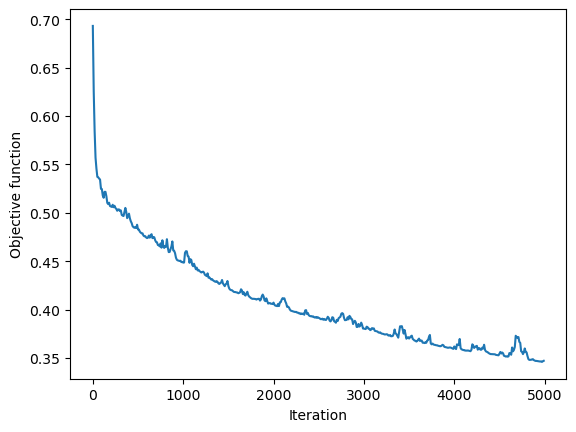

In [18]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.05
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MySGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

Test accuracy 0.8044835704780428


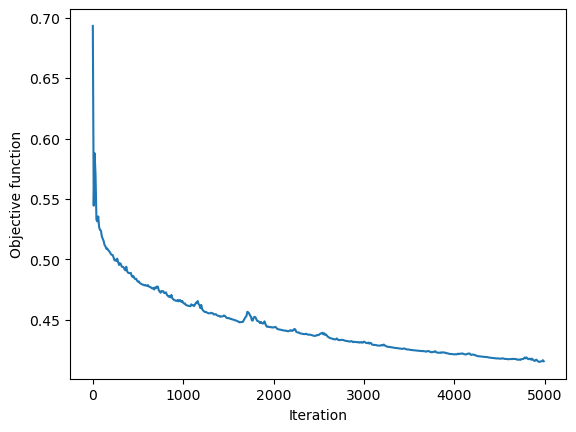

In [19]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = lambda t: 1 / np.sqrt(t+1)

mlr = MySGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=0)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

## Question 2.2 (private SGD)

We will now implement and experiment with DP-SGD:
1. Given the normalization applied to the data, what is the sensitivity of an individual gradient?
2. Following the model of the function `sgd`, implement a new function `private_sgd` which implements DP-SGD **with mini-batch size of 1 and no regularization**. It can take as input the desired value of $\epsilon$ and $\delta$ for the $(\epsilon,\delta)$-DP, or alternatively the standard deviation of the Gaussian noise to add at each iteration. Note: you do not need to make the objective plotting part private (this is only for monitoring).
3. Following the model of the class `MySGDLogisticRegression`, implement a new class `MyPrivateSGDLogisticRegression` which implements differentially private logistic regression trained using your DP-SGD implementation above.
4. Experiment with different values of $\epsilon$ and $\delta$, number of iterations and step size, and study the effect on the convergence of SGD as well as the test accuracy of the resulting model. Describe your observations. How does the level of privacy affect the choice of the number of iterations? How can we choose the number of iterations and step size in practice?

**Implémentation de la classe MyPrivateSGDLogisticRegression**


In [21]:
from src.SGD_private import MyPrivateSGDLogisticRegression,private_sgd

1.4312494390359727
0.10801882558762055
0.05612742898180284
0.03791389242479397
0.02862498878071945
2.98484451895811
0.22527128444966862
0.11705272623365136
0.07906872897902277
0.0596968903791622


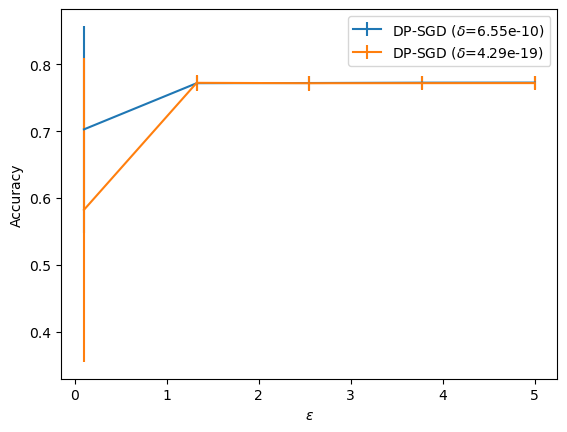

In [24]:
lamb = 0
n_iter = 500
n_batch = 1
gamma = 0.2
# gamma = lambda t: 1 / np.sqrt(t)
l = 1 # borne gradient

eps_list = np.linspace(0.1, 5.0, num=5)
delta_list = [1. / n_train**2, 1. / n_train**4]
n_runs = 10

freq_obj_eval = 10
obj_list = np.zeros(( len(eps_list), len(delta_list), n_runs, n_iter//freq_obj_eval ))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
accuracy = np.zeros((len(eps_list), len(delta_list), n_runs))
for j, delta in enumerate(delta_list):
    for i, eps in enumerate(eps_list):
        print(16*l*np.sqrt( n_iter* np.log(2/delta)* np.log(2.5*n_iter/(delta*n)) )   / (n*eps))
        for r in range(n_runs):
            mlr = MyPrivateSGDLogisticRegression(gamma, n_iter, eps, delta, l, lamb, n_batch=n_batch, random_state=r, freq_obj_eval=freq_obj_eval)
            mlr.fit(X_train, y_train)
            accuracy[i, j, r] = mlr.score(X_test, y_test)
            obj_list[i,j,r] = np.array(mlr.obj_list_)


    ax.errorbar(eps_list, accuracy[:, j, :].mean(axis=1), accuracy[:, j, :].std(axis=1),
                label='DP-SGD ($\delta$=' + "{:.2e}".format(delta) + ')')



plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy")
ax.legend()
plt.show()

In [ ]:
lamb = 0
n_iter = 1000
n_batch = 1
gamma = 0.2
# gamma = lambda t: 1 / np.sqrt(t)
l = 1 # borne gradient

eps_list = np.linspace(0.1, 5.0, num=5)
delta_list = [1. / n_train**2, 1. / n_train**4]
n_runs = 10

freq_obj_eval = 10
obj_list = np.zeros(( len(eps_list), len(delta_list), n_runs, n_iter//freq_obj_eval ))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
accuracy = np.zeros((len(eps_list), len(delta_list), n_runs))
for j, delta in enumerate(delta_list):
    for i, eps in enumerate(eps_list):
        print(16*l*np.sqrt( n_iter* np.log(2/delta)* np.log(2.5*n_iter/(delta*n)) )   / (n*eps))
        for r in range(n_runs):
            mlr = MyPrivateSGDLogisticRegression(gamma, n_iter, eps, delta, l, lamb, n_batch=n_batch, random_state=r, freq_obj_eval=freq_obj_eval)
            mlr.fit(X_train, y_train)
            accuracy[i, j, r] = mlr.score(X_test, y_test)
            obj_list[i,j,r] = np.array(mlr.obj_list_)


    ax.errorbar(eps_list, accuracy[:, j, :].mean(axis=1), accuracy[:, j, :].std(axis=1),
                label='DP-SGD ($\delta$=' + "{:.2e}".format(delta) + ')')



plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy")
ax.legend()
plt.show()

2.063831543614996


Nous avons implémenté une descente de gradient pour une régression logistique.
La fonction de loss sera : $L(\theta, x, y)$
Elle est $∥x∥$-Lipschitz et convexe.
De plus les données sont normalisées donc nous pouvons considérer que la perte est bornée par $1$.

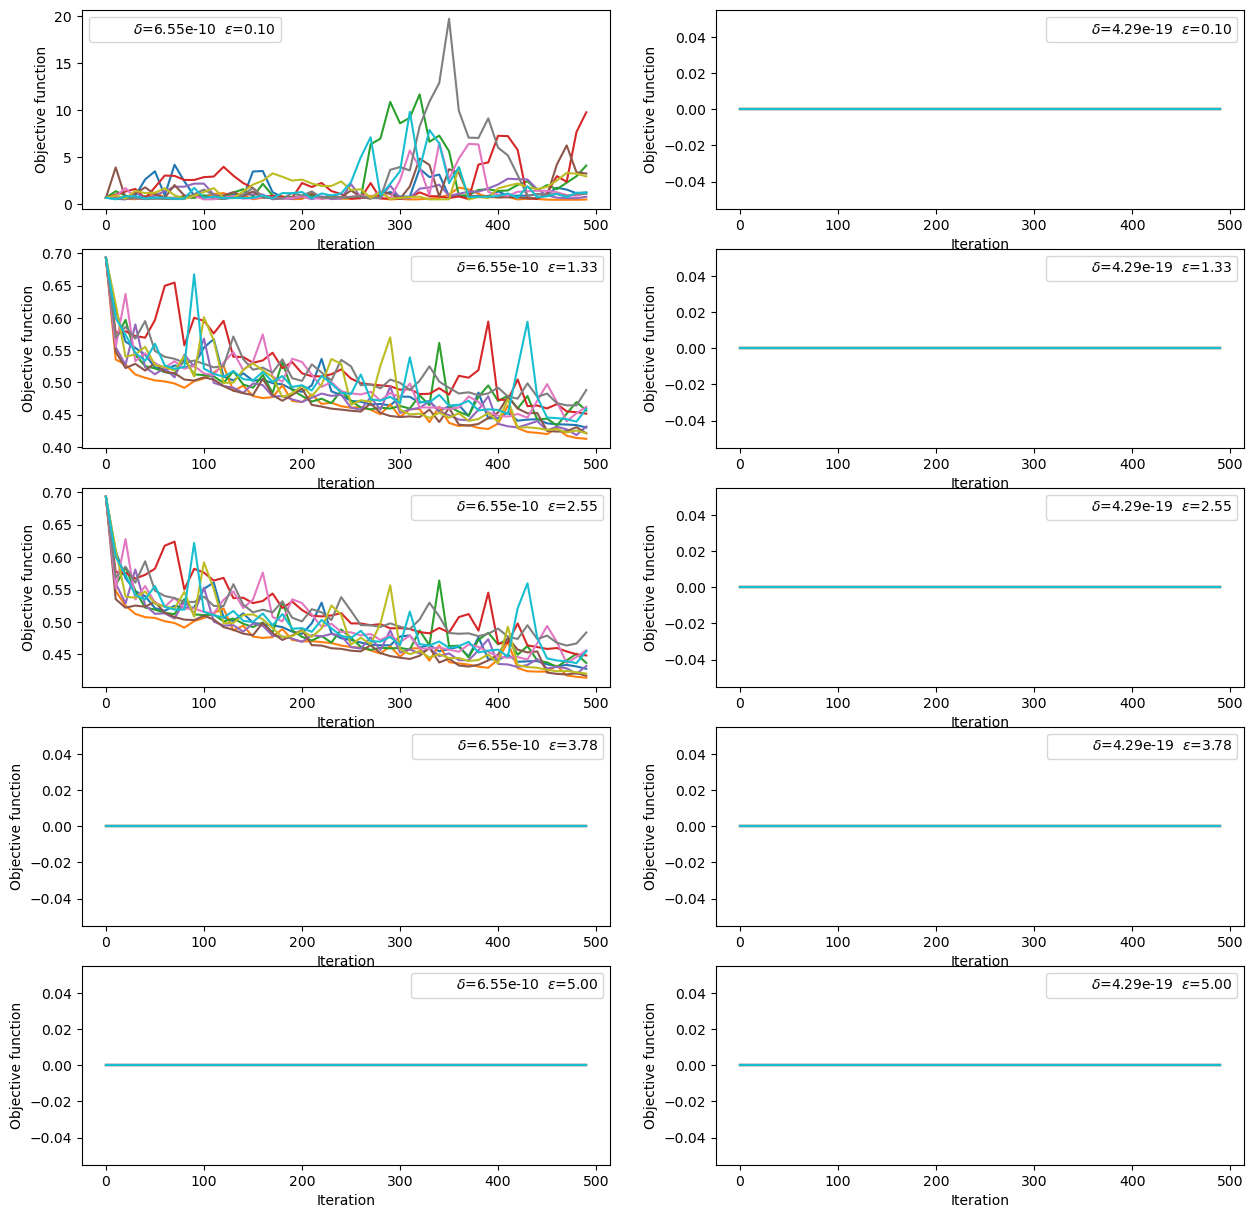

In [23]:
fig = plt.figure(figsize = (15,15))
iter_list = np.arange(n_iter//freq_obj_eval) * mlr.freq_obj_eval

for j, delta in enumerate(delta_list):
    #plt.subplot(len(delta_list),1,j+1)
    for i, eps in enumerate(eps_list):
        plt.subplot(len(eps_list),len(delta_list),i*(len(delta_list)) + j+1)
        for r in range(n_runs):
            plt.plot(iter_list, obj_list[i,j,r,:])
        plt.plot([],[],' ', label = "$\delta$=" + "{:.2e}".format(delta) + "  $\epsilon$=" + "{:.2f}".format(eps))
        plt.xlabel("Iteration")
        plt.ylabel("Objective function")
        plt.legend()
plt.show()

## <font color='blue'>Bonus Question</font> (extending the scope of private SGD)
*(You won't be penalized if you don't answer this question; but can get bonus points if you do)*

Let us consider the following extensions, which were briefly discussed in the lecture:
1. *$\ell_2$-regularization*: What is the sensitivity of the stochastic gradient when adding $\ell_2$-regularization to the objective (parameter `lamb` in the code above)? Adapt your code if needed.
2. *Mini-batch*: What is the sensitivity of a stochastic gradient when it is evaluated on a mini-batch of $b$ data points (parameter `n_batch` in the code above)? Adapt your code if needed.
3. *Gradient clipping*: If the loss function $L$ is not Lipschitz, or when the Lipschitz constant is difficult to bound, the idea of gradient clipping consists in rescaling each individual gradient that have a norm larger than some constant $C$ to have norm equal to $C$:
$$\text{clip}(\nabla L(\theta;x,y), C) = \min\Big(1,\frac{C}{\|\nabla L(\theta;x,y)\|_2}\Big)\nabla L(\theta;x,y)$$

Explain how this allows to bound the gradient sensitivity without any assumption on the Lipschitzness of the loss. Implement this variant in a function `private_sgd_with_clipping` and explore how to choose the value of $C$ for logistic regression on the *unnormalized* version of your dataset.

Quand nous ajoutons une régularisation $\ell_2$ la fonction de loss devient : $L(\theta, x, y) + \dfrac{1}{2} \| \theta \|_2$.

Comme L() est $\|x\|$-lipschitz et que $\ell_2$ est 1-lipschitz, cette nouvelle fonction de loss est $(\|x\|+1)$-lipschitz.

Avec le "gradient clipping", on garantit que le gradient est bornée par $C$. Ainsi la sensibilité du gradient est bornée par $2C$.


In [ ]:
def private_sgd_with_clipping(X, y, gamma, n_iter, obj_and_grad, theta_init, epsilon, delta, l, C, n_batch=1, freq_obj_eval=10,
                              n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm with clipping

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic
    epsilon : float
        epsilon parameter of differential privacy
    delta : float
        delta parameter of differential privacy
    C : float
        clipping parameter


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """

    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]


    sigma = 16*l*np.sqrt( n_iter* np.log(2/delta)* np.log(2.5*n_iter/(delta*n_batch)) )   / (n_batch*epsilon)

    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        # TO COMPLETE
        idx_batch = rng.choice(range(0,n), n_batch, replace=False)
        eta = rng.normal(0,sigma,np.size(theta))
        _, grad = obj_and_grad(theta, X[idx_batch, :], y[idx_batch])
        grad = np.minimum(1, C/np.linalg.norm(grad,2))*grad # clip gradient
        theta = theta - grad * (gamma_func(t) + eta)


    return theta, obj_list